# State Estimation

This notebook outlines state estimation using the TCLab hardware. 

## Output Feedback Control 

Let's begin our investigations by considering the single loop control problem for a single heater/sensor assembly in the Temperature Control Lab. First we define a setpoint function that we'll be using throughout the notebook.

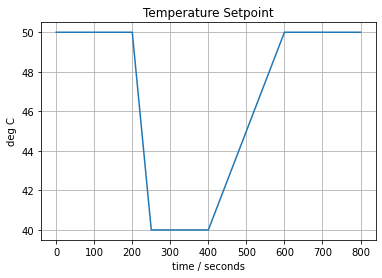

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Temperature Setpoint
def SP(t):
    tp = [  0,  200,  250,  400,  600]
    Tp = [ 50,   50,   40,   40,   50]
    return np.interp(t, tp, Tp)

t = np.linspace(0, 800, 801)
fig, ax = plt.subplots(1, 1)
ax.plot(t, SP(t))
ax.set_title('Temperature Setpoint')
ax.set_xlabel('time / seconds')
ax.set_ylabel('deg C')
ax.grid(True)

Next we implement a simple relay controller using the Python `yield` statement.

In [2]:
# Relay Control
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        SP, PV = yield MV
        MV = MV_max if PV < SP else MV_min

Finally, we put these together to form a control system for the regulation of temperature T1 to the desired setpoint using relay control to manipulate `U1`.

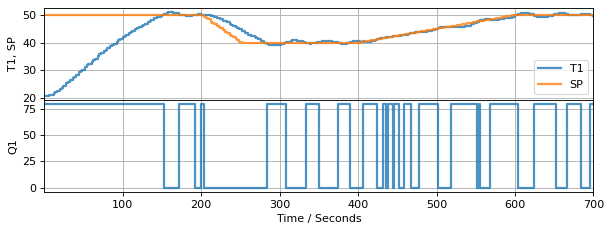

TCLab Model disconnected successfully.


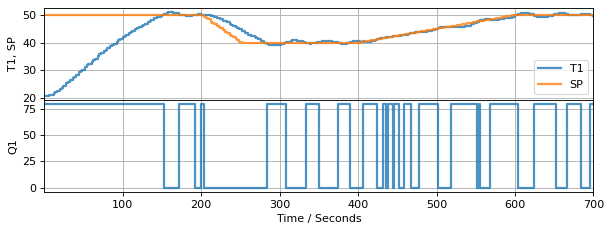

In [3]:
from tclab import setup, clock, Historian, Plotter

# run time
t_final = 700 
t_step = 2

# create a controller instance
controller = relay(MV_min=0, MV_max=80)
U1 = next(controller)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1)])
    p = Plotter(h, t_final, layout=[('T1', 'SP'), ['Q1']])
    for t in clock(t_final, t_step):
        T1 = lab.T1
        U1 = controller.send([SP(t), T1])
        lab.Q1(U1)
        p.update(t) 

## The Trouble with Output Feedback

So how did we do? Let's look at the response of the measured sensor temperature and heater input.

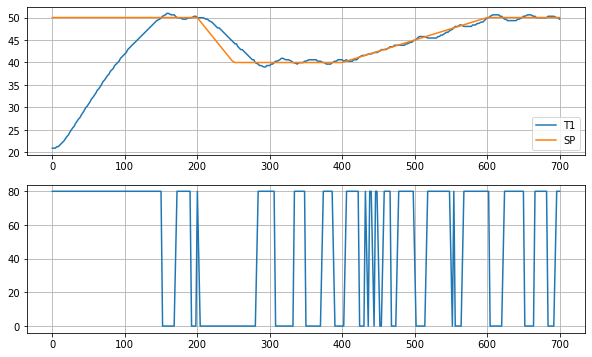

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(h.logdict["Time"], h.logdict["T1"], label="T1")
ax[0].plot(h.logdict["Time"], h.logdict["SP"], label="SP")
ax[0].grid(True)
ax[0].legend()

ax[1].plot(h.logdict["Time"], h.logdict["Q1"], label="Q1")
ax[1].grid(True)

As shown, the controller does a reasonably good job of controlling the sensor temperature. But if the goal is to control heater temperature, then there is no assuronce the controller has accomplished that objective.

![](figures/FeedbackControlDiagram2.png)

In the context of control, the control variable (CV) is heater temperature, the measured process variable (PV) is the sensor temperature, and we haven't yet established the relationship between them.

## Heater/Sensor Model

In chapter two we explored various models for describing the response of the heater/sensor assemblies to heater inputs. For heater/sensor assembly 1 we developed the following model

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1 u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}

where $C^H_p$ and $C^S_p$ are the gross heat capacities of the heater and sensor, respectively, $U_a$ is the heat transfer coefficient characterizing the exchange of heat with the surroundings, and $U_b$ is a heat transfer coefficient between the heater and sensor.

\begin{align}
\frac{dT_{H,1}}{dt} & = -\frac{U_a+U_b}{C^H_p}T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1}) 
\end{align}

Where measured temperature, that is, the temperature recorded by the Arduino, $T_1$ is given by

$$T_1 = T_{S,1}$$

## Converting to a State-Space Model

The same model can be written in a **state-space** matrix/vector format:

\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}

where

$$x = \begin{bmatrix} T_{H,1} \\ T_{S,1} \end{bmatrix}
\qquad
u = \begin{bmatrix} u_1 \end{bmatrix}
\qquad
d = \begin{bmatrix} T_{amb} \end{bmatrix}
\qquad
y = \begin{bmatrix} T_{S,1} \end{bmatrix}$$

and

$$A = \begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} \end{bmatrix}
\qquad
B_u = \begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix}
\qquad
B_d = \begin{bmatrix} \frac{U_a}{C_p^H} \\ 0 \end{bmatrix}
\qquad
C = \begin{bmatrix} 0 & 1 \end{bmatrix}$$

By common convention, in state-space models the vector $x$ contains all variables representing the **state** of the system. The input vector $u$ is reserved for all manipulated variables (MV's), and the input vector $d$ for all disturbance variables (DV's). The vector $y$ holds all measured process variables (PV's).

## Model Predictions

For a sufficiently small time step, the change in state is approximated to first-order by

$$\frac{dx}{dt}\bigg\rvert_{k-1} \approx \frac{x_{k} - x_{k-1}}{t_k - t_{k-1}}$$ 

Substituting we get

$$\frac{x_{k} - x_{k-1}}{t_k - t_{k-1}} = A x_{k-1} + B_u u_{k-1} + B_d d_{k-1}$$

which is rearranged to give a means of predicting a value $x_{k}$ at $t_k$ given information available up to time $t_{k-1}$

$$x_{k} = x_{k-1} + (t_k - t_{k-1}) ( A x_{k-1} + B_u u_{k-1} + B_d d_{k-1})$$

We call this the state update equation.

To put this to work, we first use the Python `yield` statement to create co-routine that accepts values for time and the manipulated process inputs, then uses those values to update an estimate of the state.

In [5]:
import numpy as np

# This generate creates a model of the temperature control lab to run in parallel
# with real-time control. This uses the Python 'yield' statement to 
# share data with a calling script.

# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
Ua = 0.050            # heat transfer coefficient from heater to environment
CpH = 2.2             # heat capacity of the heater (J/deg C)
CpS = 1.9             # heat capacity of the sensor (J/deg C)
Ub = 0.021            # heat transfer coefficient from heater to sensor
Tamb = 21             # ambient room temperature

# state space model
A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
Bu = np.array([[alpha*P1/CpH], [0]])     # single column
Bd = np.array([[Ua/CpH], [0]])           # single column
C = np.array([[0, 1]])                   # single row

u_initial = np.array([0])                # initial manipulable input
d_initial = [Tamb]                       # initial disturbance input
x_initial = np.array([Tamb, Tamb])       # initial steady state

def tclab_model():
    # initialize variables
    t_now = 0
    x_now = x_initial
    d = d_initial
    
    while True:
        # yield current state, get MV for next period
        t_next, Q = yield x_now
        
        # compute next state
        u = [Q]
        x_next = x_now + (t_next - t_now)*(np.dot(A, x_now) + np.dot(Bu, u) + np.dot(Bd, d))
        
        # update time and state
        t_now = t_next
        x_now = x_next

Let's run the model in parallel with the event loop, feeding both the hardware and model the same information.

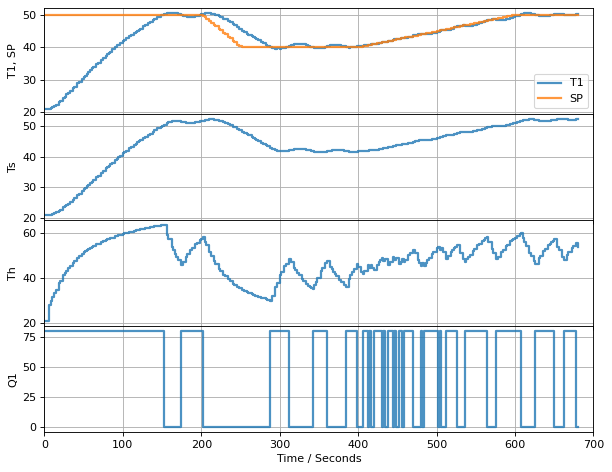

In [ ]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

t_final = 700        # run time

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)

# create model instance
model = tclab_model()
Th, Ts = next(model)

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP', lambda: SP(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1), 
                   ('Th', lambda: Th), ('Ts', lambda: Ts)])
    p = Plotter(h, t_final, layout=[['T1', 'SP'], ['Ts'], ['Th'], ['Q1']])
    for t in clock(t_final, 2):
        T1 = lab.T1                        # get a new measurement
        Th, Ts = model.send([t, U1])       # update estimates for the current Th, Ts
        U1 = controller.send([SP(t), T1])  # compute the value of U1 for the next time interval
        lab.Q1(U1)
        p.update(t)

## The Trouble with Model Predictions

So far what we're doing is interesting, but with no real consequence for control. All we are doing is passing input information along to the model so that it can operate in parallel with our actual hardware. 

### Issue 1: Heater temperature is markedly different from the sensor temperature.

Let's first compare the setpoint to the heater temperature predicted by the model.

Text(394.0, 52.43422318426067, 'Predicted Heater Temperature Th')

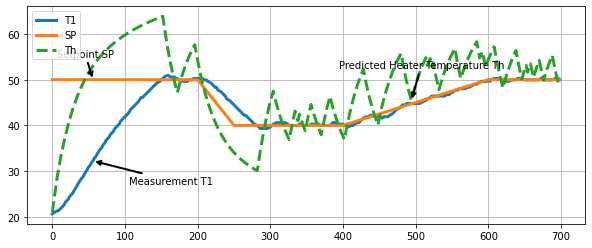

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(h.logdict["Time"], h.logdict["T1"], label="T1", lw=3)
ax.plot(h.logdict["Time"], h.logdict["SP"], label="SP", lw=3)
ax.plot(h.logdict["Time"], h.logdict["Th"], "--", label="Th", lw=3)
ax.legend()
ax.grid(True)

xy = np.array((h.logdict["Time"][20], h.logdict["T1"][20]))
ax.annotate('Measurement T1', xy=xy, xytext=xy + np.array([50, -5]),
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][20], h.logdict["SP"][20]))
ax.annotate('Setpoint SP', xy=xy, xytext=xy + np.array([-50, 5]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][194], h.logdict["Th"][194]))
ax.annotate('Predicted Heater Temperature Th', xy=xy, xytext=xy + np.array([-100, 7]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

We see that the heater temperature predicted by the model is substantially different from the desired setpoint. Using the measured temperature as a proxy for heater temperature turns out not to work for applications requiring precise temperature control.

### Issue 2: The model may not be an accurate predictor of temperatures.

Next, let's compare the actual temperature measurements to the sensor temperature predicted by the model.

Text(296.02, 51.983499315311796, 'Predicted Sensor Temperature Ts')

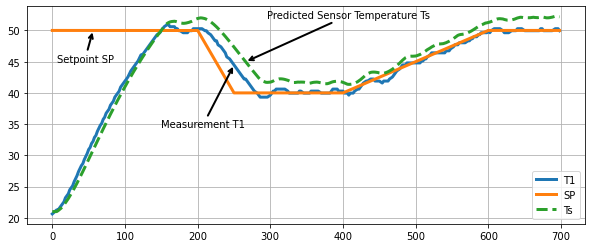

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(h.logdict["Time"], h.logdict["T1"], label="T1", lw=3)
ax.plot(h.logdict["Time"], h.logdict["SP"], label="SP", lw=3)
ax.plot(h.logdict["Time"], h.logdict["Ts"], "--", label="Ts", lw=3)
ax.legend()
ax.grid(True)

xy = np.array((h.logdict["Time"][98], h.logdict["T1"][98]))
ax.annotate('Measurement T1', xy=xy, xytext=xy + np.array([-100, -10]),
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][20], h.logdict["SP"][20]))
ax.annotate('Setpoint SP', xy=xy, xytext=xy + np.array([-50, -5]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][105], h.logdict["Ts"][105]))
ax.annotate('Predicted Sensor Temperature Ts', xy=xy, xytext=xy + np.array([30, 7]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

We see is a notable difference between the sensor temperature predicted by the model and the actual measurement.

## Incorporating Measurements

As this example has made clear, we need a notation that distinguishes the actual state of the physical system from our best estimate of that state. We will use $\hat{x}$ to denote our best estimate of $x$, and use $\hat{y}$ to denote the measurement that would result from $\hat{x}$. We can write two systems of equations corresponding to the dynamics of the actual process and to a model of the process.

* **Process**
\begin{align*}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align*}

* **Prediction Model**
\begin{align*}
\frac{d\hat{x}}{dt} & = A \hat{x} + B_u u + B_d \hat{d}\\
\hat{y} & = C \hat{x}
\end{align*}

We have made a bold assumption that the equatons and coefficients in these systems are the same. Any differences are due to different values for the states $x$ and $\hat{x}$, and differences between unmeasured process disturbances $d$ and our estimate for those disturbances, $\hat{d}$.

As we learned from the example, the problem with using this formulation for the feedback control of unmeasured states is that we are neglecting available measurements. This is a obvious oversight. How can this be addressed?

A brilliant answer to this question was given by David Luenberger in the early 1960's while a graduate student at Stanford University. The answer was to modify the second system of equations to include a corrective action due to differences between actual process measurements and predictions of what those measurments should be.

* **Observer**
\begin{align*}
\frac{d\hat{x}}{dt} & = \underbrace{A \hat{x} + B_u u + B_d \hat{d}}_{\text{prediction}} - \underbrace{L(\hat{y} - y)}_{\text{correction}}\\
\hat{y} & = C \hat{x}
\end{align*}

The idea is that if predicted measurements $\hat{y}$ are different from the actual measurements $y$, then corrective action will be imposed to modify the state estimates. In a sense, this is imposing feedback control on our process model to cause the model states to track the actual process states. We will need find values for a matrrix $L$ (after Luenberger?) to make this work.

Taking the difference between predicted and actual measurements, we find

\begin{align*}
\hat{y} - y & = C \hat{x} - C x \\
& = C\underbrace{(\hat{x} - x)}_e
\end{align*}

where $e = \hat{x} - x$ is error in our prediction of the state. Subtracting the new model equations from the process model, we get an expression for the dynamics of the model error $e = \hat{x} - x$

\begin{align*}
\frac{de}{dt} & = \frac{d\hat{x}}{dt} - \frac{dx}{dt} \\
\\
\frac{de}{dt} & = (A\hat{x} + B_u u + B_d \hat{d}) - (Ax + B_u u B_d d + L(C\hat{x} - C x)) \\
\\
\frac{de}{dt} & = (A - LC)(\hat{x} - x) + B_d(\hat{d} - d) \\
\\
\implies \frac{de}{dt} & = (A - LC) e + B_d(\hat{d} - d) 
\end{align*}

The choice of $L$ determines observer performance. What we seek is a matrix $L$ such that $A - LC$ results in error $e$ that quickly decays to zero.

### Fun with Eigenvalues

In [9]:
import numpy as np

# get the eigenvalues of A and report time constants
eigenvalues, _ = np.linalg.eig(A)
print('Time constants of A are:', -1.0/np.real(eigenvalues), 'seconds')

Time constants of A are: [ 27.44985926 145.02633122] seconds


With a little trial and error, find values for $L$ that produce acceptable time constants. Later we will discuss more deliberate methods for finding values for $L$.

In [10]:
L = np.array([[0.4], [0.2]])

eigenvalues_observer, _ = np.linalg.eig(A - np.dot(L, C))
print('Time constants of A - LC are:', -1.0/np.real(eigenvalues_observer), 'seconds')

Time constants of A - LC are: [16.38248746  5.48592793] seconds


### Model Prediction / Measurement Correction

Making the substitution $\hat{y} = C\hat{x}$, the observer equation becomes

\begin{align*}
\frac{d\hat{x}}{dt} & = \underbrace{A \hat{x} + B_u u + B_d \hat{d}}_{\text{prediction}} - \underbrace{L(C\hat{x} - y)}_{\text{correction}}
\end{align*}

As before, we can try approximating the derivative with a first order difference formula over small intervals of time. One clever detail is to choose the start of the interval, time $t_{k-1}$, to evaluate the model prediction part of the obsever equation, and use the process measurement available at end of the interval, time $t_k$, to evaluate the correction term.

$$\frac{\hat{x}_{k} - \hat{x}_{k-1}}{t_k - t_{k-1}} = \underbrace{A \hat{x}_{k-1} + B_u u_{k-1} + B_d \hat{d}_{k-1}}_{\text{prediction at time $t_{k-1}$}} - \underbrace{L(C \hat{x}_k - y_k)}_{\text{correction at time $t_k$}}$$

For this purpose we introduce some extra notation. We use $\hat{x}_{k-1}$ to represent the state estimate at time $t_{k-1}$ using all information up to time $t_{k-1}$. Given knowledge of the manipulated inputs $u_{k-1}$ and an estimate of the disturbances $\hat{d}_{k-1}$, we will use the model to create a predicted state $\hat{x}_k^{pred}$ for time $t_k$. A measurement is then taken at time $t_k$ which is used to produce a new estimate $\hat{x}_k$. 

At each time step $t_k$ there are two calculations to perform:

* **Model Prediction:** Use the model to update the state to the next time step, i.e., $\hat{x}_{k-1|k-1} \rightarrow \hat{x}_{k|k-1}$ with the equation

$$\hat{x}_k^{pred} = \hat{x}_{k-1} + (t_k - t_{k-1}) ( A \hat{x}_{k-1} + B_u u_{k-1} + B_d \hat{d}_{k-1})$$

* **Measurement Correction:** Use measurement $y_k$ to update $\hat{x}_{k}^{pred} \rightarrow \hat{x}_{k}$ with the equation

$$\hat{x}_{k} = \hat{x}_{k}^{pred} - (t_k - t_{k-1}) L (C\hat{x}_{k}^{pred} - y_k)$$ 

While the notation may be a little daunting, the underlying concepts are quite straightforward. At each time step we have two calculations to perform. First, use all available information to predict the current state using the process model. Second, when a measurement becomes available, compare the measure to the model prediction and apply an appropriate correction to the state estimate. 

Let's see how this works in practice. The next cell introduces `tclab_observer`, Python generator that creates instances of observers using the two-state model.

In [11]:
def tclab_observer(L):
    # initialize variables
    t_now = 0
    x_now = x_initial
    d = d_initial                         # estimate of unmeasured disturbances
    
    while True:
        # yield current state, get MV for next period
        t_next, Q, T_measured = yield x_now
        
        # model prediction
        u = [Q]
        d = [Tamb]
        x_predict = x_now + (t_next - t_now)*(np.dot(A, x_now) + np.dot(Bu, u) + np.dot(Bd, d))
        
        # measurement correction
        y = np.array([T_measured])
        x_correct = x_predict - (t_next - t_now)*np.dot(L, np.dot(C, x_predict) - y)
        
        # update time and state
        t_now = t_next
        x_now = x_correct

The first experiment is to test if the observer does a better job of matching the model response to the measured temperatures.

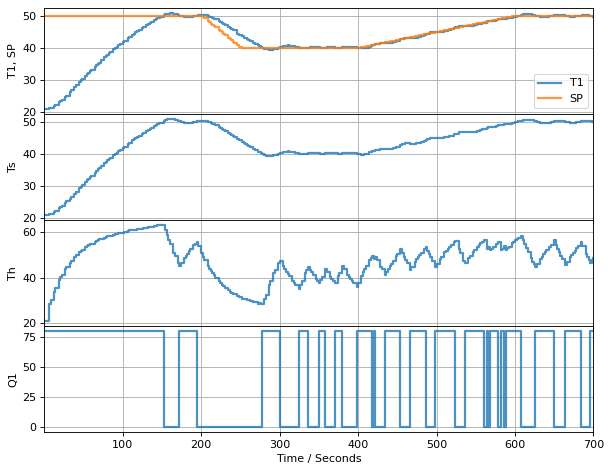

TCLab Model disconnected successfully.


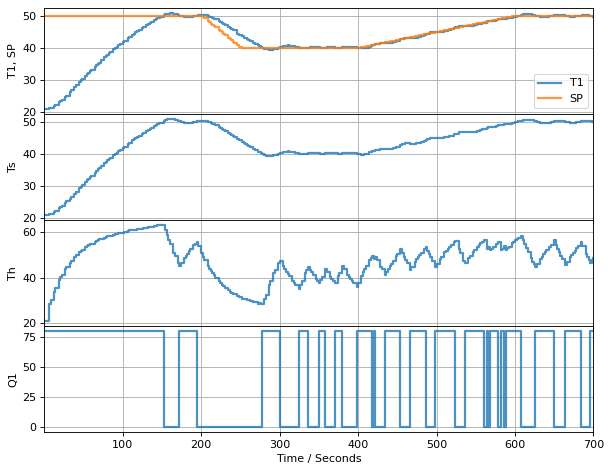

In [12]:
t_final = 700        # run time
t_step = 2

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)

# create estimator instance
L = np.array([[0.4], [0.2]])
observer = tclab_observer(L)
Th, Ts = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1), 
                   ('Th', lambda: Th), ('Ts', lambda: Ts)])
    p = Plotter(h, t_final, layout=[['T1', 'SP'], ['Ts'], ['Th'], ['Q1']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        Th, Ts = observer.send([t, U1, T1])   # <= use the last value of U1 to estimate the current Th, Ts
        U1 = controller.send([SP(t), T1])  # <= compute the value of U1 to use for the next time interval
        lab.Q1(U1)
        p.update(t)

Text(302.01, 47.641848189471695, 'Predicted Sensor Temperature Ts')

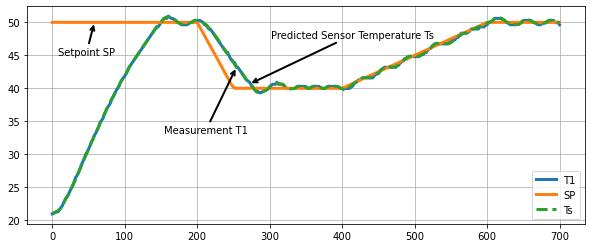

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(h.logdict["Time"], h.logdict["T1"], label="T1", lw=3)
ax.plot(h.logdict["Time"], h.logdict["SP"], label="SP", lw=3)
ax.plot(h.logdict["Time"], h.logdict["Ts"], "--", label="Ts", lw=3)
ax.legend()
ax.grid(True)

xy = np.array((h.logdict["Time"][98], h.logdict["T1"][98]))
ax.annotate('Measurement T1', xy=xy, xytext=xy + np.array([-100, -10]),
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][20], h.logdict["SP"][20]))
ax.annotate('Setpoint SP', xy=xy, xytext=xy + np.array([-50, -5]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][105], h.logdict["Ts"][105]))
ax.annotate('Predicted Sensor Temperature Ts', xy=xy, xytext=xy + np.array([30, 7]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

Text(398.0, 51.70130402872223, 'Predicted Heater Temperature Th')

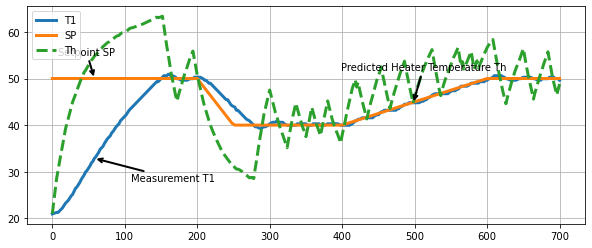

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(h.logdict["Time"], h.logdict["T1"], label="T1", lw=3)
ax.plot(h.logdict["Time"], h.logdict["SP"], label="SP", lw=3)
ax.plot(h.logdict["Time"], h.logdict["Th"], "--", label="Th", lw=3)
ax.legend()
ax.grid(True)

xy = np.array((h.logdict["Time"][20], h.logdict["T1"][20]))
ax.annotate('Measurement T1', xy=xy, xytext=xy + np.array([50, -5]),
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][20], h.logdict["SP"][20]))
ax.annotate('Setpoint SP', xy=xy, xytext=xy + np.array([-50, 5]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][194], h.logdict["Th"][194]))
ax.annotate('Predicted Heater Temperature Th', xy=xy, xytext=xy + np.array([-100, 7]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

## State Estimation and Closed-Loop Relay Control

Zounds!!  We now have an estimator that locks on to the measured value of the sensor temperature.  

Now, if we really trust our model, let's take it a step further and control the estimated heater temperature. The following cell replaaces the temperature measurement in the relay feedback using estimated heater temperature. Measurements are still be used, but for estimation raather than directly in the controller feedback.

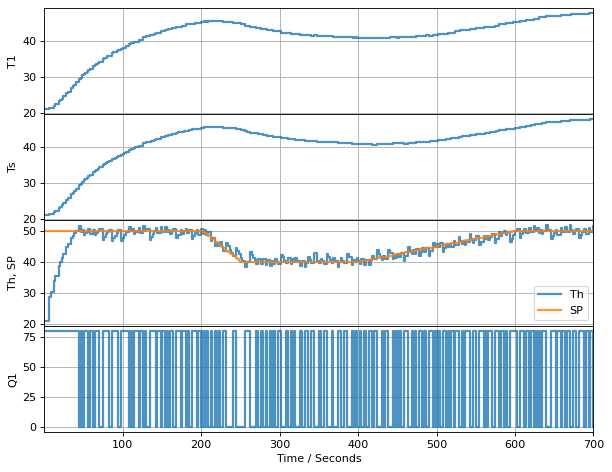

TCLab Model disconnected successfully.


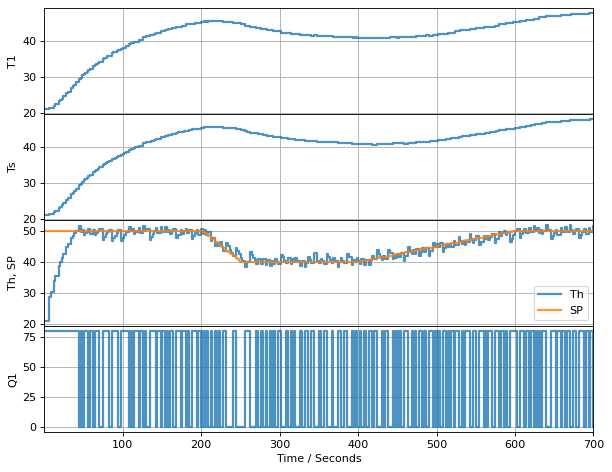

In [15]:
t_final = 700        # run time
t_step = 2

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)

# create estimator instance
L = np.array([[0.4], [0.2]])
observer = tclab_observer(L)
Th, Ts = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1), 
                   ('Th', lambda: Th), ('Ts', lambda: Ts)])
    p = Plotter(h, t_final, layout=[['T1'], ['Ts'], ['Th', 'SP'], ['Q1']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        Th, Ts = observer.send([t, U1, T1])
        U1 = controller.send([SP(t), Th]) 
        lab.Q1(U1)
        p.update(t)

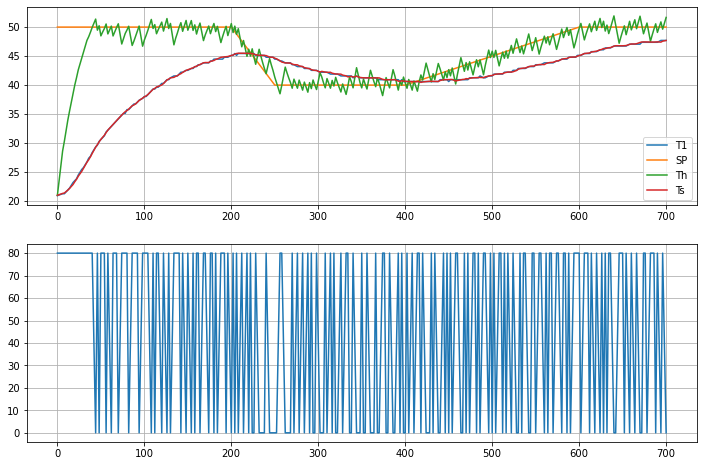

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(h.logdict["Time"], h.logdict["T1"], label="T1")
ax[0].plot(h.logdict["Time"], h.logdict["SP"], label="SP")
ax[0].plot(h.logdict["Time"], h.logdict["Th"], label="Th")
ax[0].plot(h.logdict["Time"], h.logdict["Ts"], label="Ts")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(h.logdict["Time"], h.logdict["Q1"], label="Q1")
ax[1].grid(True)